In [1]:
import torch
import torchvision

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.transforms import v2

import torch.nn as nn

from torch.optim import Adam

import os
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image

In [6]:
any(['jpg', 'png', 'jpeg']) in 'tmp.png'

TypeError: 'in <string>' requires string as left operand, not bool

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# class Pictures(Dataset):
#     def __init__(self, path, transform=None):
#         self.path = path
#         self.transform = transform
#         self.data = []

#         self.generator1 = torch.Generator().manual_seed(42)
#         self.generator2 = torch.Generator().manual_seed(74)

#         for path_dir, dir_list, file_list in os.walk(path):
#             if path_dir == path:
#                 self.classes = sorted(dir_list)
#                 self.class_to_idx = {
#                     cls_name: i for i, cls_name in enumerate(self.classes)
#                 }
#                 continue
            
#             cls = path_dir.split('\\')[-1]

#             for name_file in file_list:
#                 file_path = os.path.join(path_dir, name_file)
#                 self.data.append((file_path, self.class_to_idx[cls]))
#         self.data = Storage(self.data, self.transform)

#     def split(self, test_size=0.2, val_size=0.2):
#         train, test = random_split(self.data, [1-test_size, test_size], generator=self.generator1)
#         train, val = random_split(train, [1-val_size, val_size], generator=self.generator2)
#         self.train = Storage(train, self.transform)
#         self.val = Storage(val, self.transform)
#         self.test = Storage(test, self.transform)


# class Storage:
#     def __init__(self, data, transform=None):
#         self.data = data
#         self.transform= transform

#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         file_path, target = self.data[index]
#         sample = np.array(Image.open(file_path))
#         if self.transform is not None:
#             sample = self.transform(sample)
#         return sample, target


class Pictures(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform

        self.len_dataset = 0
        self.data_list = []

        for path_dir, dir_list, file_list in os.walk(path):
            if path_dir == path:
                self.classes = dir_list
                self.class_to_idx = {
                    cls_name: i for i, cls_name in enumerate(self.classes)
                }
                continue
            cls = path_dir.split('\\')[-1]

            for name_file in file_list:
                file_path = os.path.join(path_dir, name_file)
                self.data_list.append((file_path, self.class_to_idx[cls]))

            self.len_dataset += len(file_list)

    def __len__(self):
        return self.len_dataset

    def __getitem__(self, index):
        file_path, target = self.data_list[index]
        sample = np.array(Image.open(file_path))

        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample, target

In [ ]:
transform = v2.Compose([
    v2.ToImage(),
    v2.RandomResizedCrop(size=(150, 150), antialias=True),
    v2.Grayscale(num_output_channels=3),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.5, ), std=(0.5, ))
])

In [5]:
# data = Pictures(r'C:\Users\mrmax\Downloads\cat-dog classifier\Animal Images', transform=transform)

In [6]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("d4rklucif3r/cat-and-dogs")

# print("Path to dataset files:", path) 

In [7]:
# data = Pictures(r'C:\Users\mrmax\Downloads\cat-dog classifier\Animal Images', transform=transform)
# data.split()

In [8]:
test = Pictures(r'C:\Users\mrmax\.cache\kagglehub\datasets\d4rklucif3r\cat-and-dogs\versions\1\dataset\test_set', transform=transform)
data = Pictures(r'C:\Users\mrmax\.cache\kagglehub\datasets\d4rklucif3r\cat-and-dogs\versions\1\dataset\training_set', transform=transform)
train, val = random_split(data, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

In [9]:
# img, one_hot_position = data.train[0]

# cls = data.classes[one_hot_position]

# print(f'class - {cls}')
# plt.imshow(img, cmap='gray')

In [10]:
train_loaded = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_loaded = DataLoader(dataset=val, batch_size=64, shuffle=True)
test_loaded = DataLoader(dataset=test, batch_size=64, shuffle=True)

In [11]:
def out(H_in, kernel_size, padding=0, dilation=1, stride=1):
    return int(H_in + 2 * padding - dilation * (kernel_size - 1) - 1 / stride) + 1
out(68, 5)

64

In [12]:
class NeuralNetwork(nn.Module):
    def __init__(self, input, output):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input, 12, (3, 3)),                       #(batch_size, 1, 150, 150) => (batch_size, 12, 148, 148)
            nn.ReLU(),                              
            nn.MaxPool2d(kernel_size=2, padding=0),             #(batch_size, 12, 148, 148) => (batch_size, 12, 74, 74)
            # nn.BatchNorm2d(12),
            # nn.Dropout2d(0.1),
            nn.ReLU(), 
            nn.Conv2d(12, 25, (7, 7)),                            #(batch_size, 12, 74, 74) => (batch_size, 25, 68, 68)
            nn.ReLU(),
            nn.Conv2d(25, 33, (5, 5)),                            #(batch_size, 25, 68, 68) => (batch_size, 33, 64, 64)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=0),             #(batch_size, 33, 68, 68) => (batch_size, 33, 32, 32)
            # nn.BatchNorm2d(33),
            # nn.Dropout2d(0.1),
            nn.Flatten()                                        #(batch_size, 8*34*34)
        )                                      

        self.classifier = nn.Sequential(
            nn.Linear(33*32*32, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 150),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(150, 20),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(20, output),
            nn.Sigmoid()
        )


    def forward(self, x):
        y = self.conv_layers(x)
        y = self.classifier(y)
        return y

model = NeuralNetwork(3, 2).to(device)

In [13]:
#Binary cross-entropy
loss_func = nn.BCELoss().to(device)
opt = Adam(model.parameters(), lr=1e-3)

In [14]:
# class EarlyStopping:
#     def __init__(self, mode='min', patience=10, threshold=1e-4, threshold_mode='rel'):
#         if mode not in ['min', 'max']:
#             raise ValueError(f'only max and min')
#         if threshold_mode not in ['rel', 'abs']:
#             raise ValueError(f'only rel and abs')
#         if not isinstance(patience, int):
#             raise TypeError(f'patience should be int')
#         if not isinstance(threshold, float):
#             raise TypeError(f'threshold should be float')
#         if threshold >= 1.0:
#             raise ValueError(f'threshold should be less than 1.0')
        
#         self.mode = mode
#         self.patience = patience
#         self.threshold = threshold
#         self.threshold_mode = threshold_mode
#         self.count = 0
#         self.best = None

#     def __call__(self, trached_parameter):
#         current = float(trached_parameter)
#         if self.best is None:
#             self.best = current
#             return False
        
#         if self.changed_better(current, self.best):
#             self.best = current
#             self.count = 0
#         else:
#             self.count += 1

#         if self.count >= self.patience:
#             self.count = 0
#             return True
#         return False
    
#     def changed_better(self, current, best):
#         if self.mode == 'min' and self.threshol_mode == 'rel':
#             return current < best - best * self.threshold
        
#         elif self.mode == 'min' and self.threshold_mode == 'abs':
#             return current < best - self.threshold
        
#         elif self.mode == 'max' and self.threshold_mode == 'rel':
#             return current > best + best * self.threshold
        
#         elif self.mode == 'max' and self.threshold_mode == 'abs':
#             return current > best + self.threshold
    
        

In [15]:
# state = torch.load('model_state_dict_5_epochs.pt')
# current_model = NeuralNetwork(28*28, 10).to(device)
# current_model.load_state_dict(state)

In [16]:
class Train:
    def __init__(self, model, EPOCHS=5, name_for_save='model'):
        self.mean_train_loss = []
        self.mean_train_acc = []
        self.mean_val_loss = []
        self.mean_val_acc = []
        
        model.train()

        threshold = 0.1

        maxAcc = -1
        for epoch in range(EPOCHS):
            model.train()

            accuracies = []
            losses = []
            train_loop = tqdm(train_loaded, leave=False)
            for i, data in enumerate(train_loop):
                x = data[0].to(torch.float32).to(device)
                targets = data[1]

                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)

                pred = model(x)
                loss = loss_func(pred, targets)
                acc = self.accuracy(pred, targets)

                accuracies.append(acc)
                losses.append(loss.item())

                if i % 100 == 0:
                    print(f'epoch {epoch}   iteration {i+epoch*len(train_loaded)}, train accuracy: {acc:.2f}, loss: {loss:.4f}')

                opt.zero_grad()
                loss.backward()
                opt.step()

            acc_mean = np.mean(np.array(accuracies))
            self.mean_train_acc.append(acc_mean)

            los_mean = np.mean(np.array(losses))
            self.mean_train_loss.append(los_mean)


            print()
            print('='*50)

            model.eval()

            accuracies = []
            losses = []
            for i, data in enumerate(val_loaded):
                x = data[0].to(torch.float32).to(device)
                targets = data[1]

                targets = targets.reshape(-1).to(torch.int32)
                targets = torch.eye(2)[targets].to(device)

                pred = model(x)
                loss = loss_func(pred, targets)

                accuracies.append(self.accuracy(pred, targets))
                losses.append(loss.item())

            acc_mean = np.mean(np.array(accuracies))
            self.mean_val_acc.append(acc_mean)

            los_mean = np.mean(np.array(losses))
            self.mean_val_loss.append(los_mean)

            print(f'validation accuracy - {acc_mean:.2f}')
            print(f'validation loss\t- {los_mean:.4f}')
            
            if acc_mean - threshold > maxAcc and acc_mean >= 0.7:
                maxAcc = acc_mean
                torch.save(model.state_dict(), f'models/{name_for_save}_{epoch}_{maxAcc:.2f}.pth')
                print(f'model is saved because mean_accuracy = {acc_mean:.2f} and it\'s best')

            print('='*50)
            print()

    def accuracy(self, output, labels):
        pred = torch.argmax(output, dim=1)
        corrects = (pred == labels.argmax(dim=1)).sum().item()
        return corrects / len(labels)
    
    def acc_plot_show(self):
        plt.plot(self.mean_train_acc)
        plt.plot(self.mean_val_acc)
        plt.legend(['acc_train', 'acc_val'])
        plt.show()

    def loss_plot_show(self):
        plt.plot(self.mean_train_loss)
        plt.plot(self.mean_val_loss)
        plt.legend(['loss_train', 'loss_val'])
        plt.show()


In [17]:
class Test:
    def __init__(self, model):
        accuracies = []

        model.eval()
        with torch.no_grad():

            test_loop = tqdm(test_loaded, leave=False)
            for i, data in enumerate(test_loop):
                x = data[0].to(torch.float32).to(device)
                targets = data[1].reshape(-1).to(torch.int64).to(device)
                one_hot_targets = torch.eye(2).to(device)[targets]

                #прямой проход и расчет ошибки модели
                pred = model(x)

                accuracies.append(self.accuracy(pred, one_hot_targets))


            acc_mean = np.mean(np.array(accuracies))
            print(f'test accuracy - {acc_mean:.2f}')

    def accuracy(output, labels):
        pred = torch.argmax(output, dim=1)
        corrects = (pred == labels).sum().item()
        return corrects / len(labels)


In [116]:
conv_model = Train(model, EPOCHS=30)

  2%|▏         | 2/100 [00:00<00:22,  4.36it/s]

epoch 0   iteration 0, train accuracy: 0.53, loss: 0.6920



validation accuracy - 0.49
validation loss		- 0.6939



  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 1   iteration 100, train accuracy: 0.48, loss: 0.6941



validation accuracy - 0.49
validation loss		- 0.6933



  0%|          | 0/100 [00:00<?, ?it/s]

epoch 2   iteration 200, train accuracy: 0.52, loss: 0.6921

  1%|          | 1/100 [00:00<00:18,  5.23it/s]


validation accuracy - 0.49
validation loss		- 0.6934



  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 3   iteration 300, train accuracy: 0.50, loss: 0.6920



validation accuracy - 0.49
validation loss		- 0.6933



  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 4   iteration 400, train accuracy: 0.61, loss: 0.6915



validation accuracy - 0.49
validation loss		- 0.6933



  0%|          | 0/100 [00:00<?, ?it/s]

epoch 5   iteration 500, train accuracy: 0.50, loss: 0.6928

  2%|▏         | 2/100 [00:00<00:18,  5.32it/s]


validation accuracy - 0.49
validation loss		- 0.6933



  1%|          | 1/100 [00:00<00:23,  4.21it/s]

epoch 6   iteration 600, train accuracy: 0.41, loss: 0.6946



validation accuracy - 0.49
validation loss		- 0.6933



  1%|          | 1/100 [00:00<00:25,  3.87it/s]

epoch 7   iteration 700, train accuracy: 0.53, loss: 0.6935



validation accuracy - 0.49
validation loss		- 0.6932



  1%|          | 1/100 [00:00<00:12,  7.91it/s]

epoch 8   iteration 800, train accuracy: 0.62, loss: 0.6902



validation accuracy - 0.49
validation loss		- 0.6932



  1%|          | 1/100 [00:00<00:23,  4.19it/s]

epoch 9   iteration 900, train accuracy: 0.55, loss: 0.6925



validation accuracy - 0.49
validation loss		- 0.6932



  2%|▏         | 2/100 [00:00<00:19,  5.01it/s]

epoch 10   iteration 1000, train accuracy: 0.47, loss: 0.6940



validation accuracy - 0.49
validation loss		- 0.6932



  0%|          | 0/100 [00:00<?, ?it/s]

epoch 11   iteration 1100, train accuracy: 0.52, loss: 0.6931

  2%|▏         | 2/100 [00:00<00:16,  5.96it/s]


validation accuracy - 0.49
validation loss		- 0.6932



  1%|          | 1/100 [00:00<00:21,  4.54it/s]

epoch 12   iteration 1200, train accuracy: 0.52, loss: 0.6929


KeyboardInterrupt: 

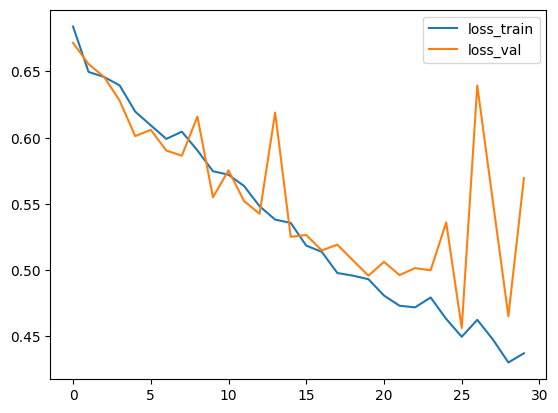

In [61]:
conv_model.loss_plot_show()

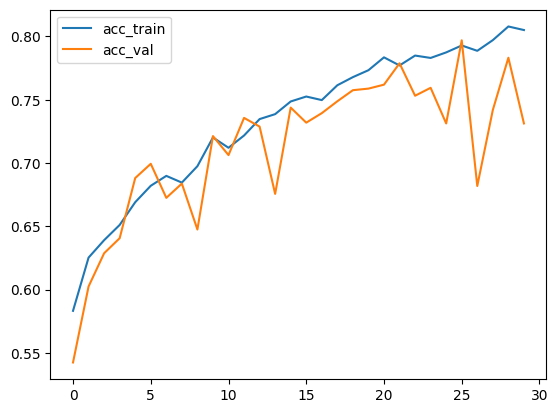

In [62]:
conv_model.acc_plot_show()

In [1]:
# weights = torch.load('models/mymodel_1_0.51.pth')
# model.load_stat_dict(weights.state_dict())
# Test(model)

In [18]:

resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet18.fc = nn.Sequential(
        nn.Linear(in_features=512, out_features=256),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=128),
        nn.Dropout(0.3),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=2),
        nn.Sigmoid()
)
resnet18

Using cache found in C:\Users\mrmax/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\mrmax\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mrmax\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
resnet18_trained = Train(resnet18.to(device), EPOCHS=30, name_for_save='resnet18')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2048 and 512x256)

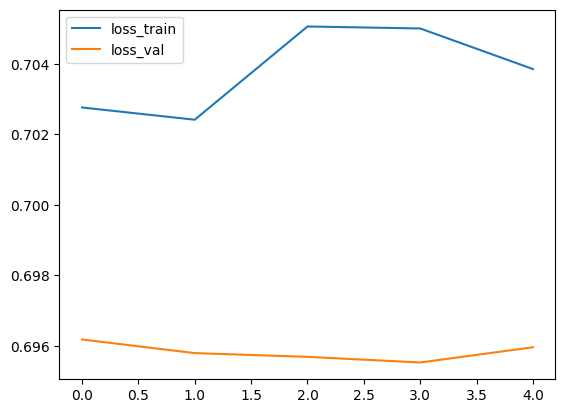

In [ ]:
resnet18_trained.loss_plot_show()

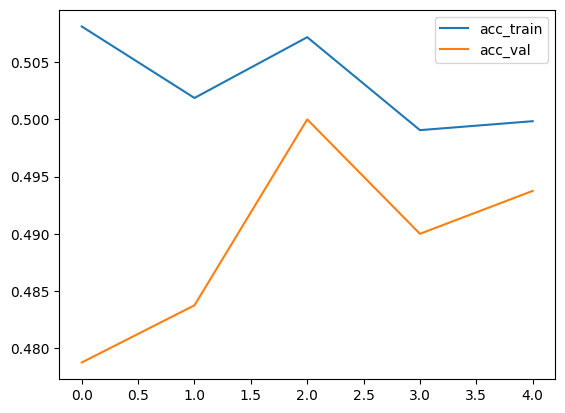

In [194]:
resnet18_trained.acc_plot_show()